# **Necessary Functions**

In [7]:
# Importing the Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
#Importing different libraries to be used in the following code
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# **Harris Corner Detection and SIFT**

## **Importing and Displaying Image**

In [9]:
imgPath='/content/drive/MyDrive/CV/Project/Data/homography.jpg'   # Path of the Image used for Image Matching
img=cv2.imread(imgPath)                                           # Reading the Image from its path
img1=img[:,:1+img.shape[1]//2,:]                                  # Since Image taken here has two different images appended next to each another, I had to crop the original image into 2 parts, each part corresponding to single image
img2=img[:,img.shape[1]//2:,:]                                    # This and above step are exclusive to this particular image input, to use the code for any other pair-of-images, either append both images next-to-each other columnwise and don't change the code, or provide two images and edit the code suitably so that one image is stored as img1 and the other as img2

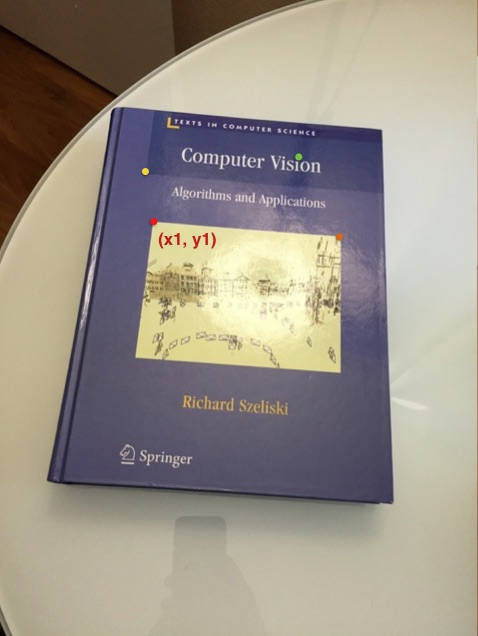

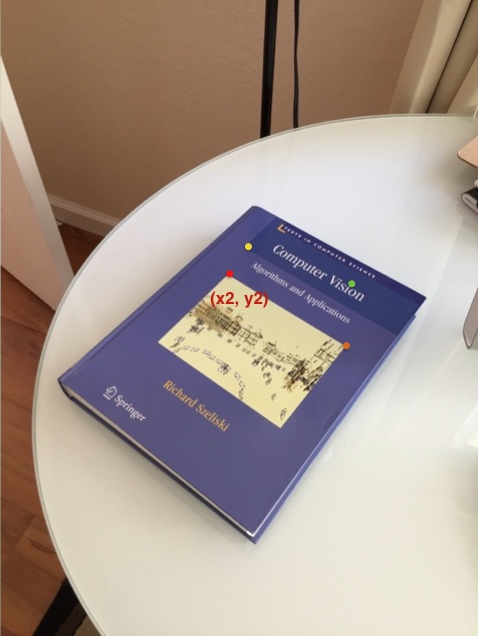

In [10]:
cv2_imshow(img1)              # Displaying Image 1
cv2_imshow(img2)              # Displaying Image 2

## **Harris Corner Detection From Scratch**

In [11]:
# Function for performing convolution with padding
def convPad(img,kernel):
  h,w=kernel.shape
  oup=np.zeros_like(img)
  if(h!=w or h%2==0 or w%2==0):                                         # Check whether the kernel is Odd-Sized and Square-Shaped or not. Only Odd-Size and Square-Shaped Kernels are allowed.
    print("Kernel is invalid! Odd Sized Square Kernel accepted only.")
    return oup
  K=h//2
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      s=0
      for kx in range(-K,K+1):
        for ky in range(-K,K+1):
          u,v=i-kx,j-ky
          if(0<=u<img.shape[0] and 0<=v<img.shape[1]):                  # Since the convolution is with padding, if any of the resultant index u and v, goes out of bounds, I don't add anything to the summation, indicating a 0 valued pixel in that location of out-of-bounds
            s+=(int(kernel[kx+K,ky+K])*int(img[u,v]))
      if(s>255.0):
        oup[i,j]=255.0                                                  # If the summation reaches value more than 255.0, which is the maximum value for a grayscale image, then I replace that pixel value with 255.0; this is called Image Clipping and it's a practical method to maintain the visualizability of the image
      elif(s<0.0):
        oup[i,j]=0.0                                                    # If the summation reaches value less than 0.0, which is the maximum value for a grayscale image, then I replace that pixel value with 0.0; this is called Image Clipping and it's a practical method to maintain the visualizability of the image
      else:
        oup[i,j]=s                                                      # If the summation lies in the range betweem 0.0 and 255.0 (both inclusive), then I keep that pixel value as it is; this is called Image Clipping and it's a practical method to maintain the visualizability of the image
  return oup

In [12]:
# Function to Detect Harris Corners from Scratch
def cornerDetect(img,k=0.05):
  SOBEL_X=np.array([[1,0,-1],[1,0,-1],[1,0,-1]])      # Defining SOBEL-X filter, which will be used to find gradient along X-direction
  SOBEL_Y=np.array([[1,1,1],[0,0,0],[-1,-1,-1]])      # Defining SOBEL-Y filter, which will be used to find gradient along Y-direction
  Ix=convPad(img,SOBEL_X)                             # Calculating Gradient along X-direction using SOBEL-X filter
  Iy=convPad(img,SOBEL_Y)                             # Calculating Gradient along Y-direction using SOBEL-Y filter

  det=((Ix**2)+(Iy**2)-((Ix*Iy)**2))                  # Calculating the determinant of matrix [[Ix*Ix,Ix*Iy],[Ix*Iy,Iy*Iy]], which helps us in finding Harris Corner Response Function
  Tr=((Ix**2)+(Iy**2))                                # Calculating the trace of matrix [[Ix*Ix,Ix*Iy],[Ix*Iy,Iy*Iy]], which helps us in finding Harris Corner Response Function
  r=det-(k*(Tr**2))                                   # Calculating the Harris Corner Response Function, with k=0.05 as default value, where k is a constant. If user provides different k, then it will be used suitably.

  return r                                            # Return the Harris Corner Response Matrix

In [13]:
img1=cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)            # Converting Image 1 from RGB (3 channel) to GrayScale (1 channel) for better corner and key-point detection
img2=cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)            # Converting Image 2 from RGB (3 channel) to GrayScale (1 channel) for better corner and key-point detection  

In [14]:
thresh=0.98                               # Threshold signifying the minimum value of the ratio of Harris Corner Response Function of a particular pixel, to the maximum value of Harris Corner Response Function

kp1=[]                                    # Array to store key-points (corners) detected in the Image 1
r1=cornerDetect(img1,0.05)                # Detecting and Retreiving Harris Corner Response Matrix for Image 1, with k=0.05.

currMax=np.max(r1)                        # Finding the maximum value of Harris Corner Response Function for Image 1
for i in range(r1.shape[0]):
  for j in range(r1.shape[1]):
    if(r1[i,j]>(thresh*currMax)):
        kp1.append(cv2.KeyPoint(j,i,1))   # Identifying those pixels in Image 1, which have ratio of Harris Corner Response Function Value to Maximum of Harris Corner Response Function Values more than the threshold

kp2=[]                                    # Array to store key-points (corners) detected in the Image 2
r2=cornerDetect(img2,0.05)                # Detecting and Retreiving Harris Corner Response Matrix for Image 2, with k=0.05.
currMax=np.max(r2)                        # Finding the maximum value of Harris Corner Response Function for Image 2
for i in range(r2.shape[0]):
  for j in range(r2.shape[1]):
    if(r2[i,j]>(thresh*currMax)):
        kp2.append(cv2.KeyPoint(j,i,1))   # Identifying those pixels in Image 2, which have ratio of Harris Corner Response Function Value to Maximum of Harris Corner Response Function Values more than the threshold

## **Getting descriptors using Harris Corners as keypoints**

In [15]:
sift=cv2.xfeatures2d.SIFT_create()    # Creating an object of SIFT_create class, which helps in computing descriptors of key-points (corners) detected using Harris Corner Detection (from scratch)
kp1,ds1=sift.compute(img1,kp1)        # Computing the descrpitors of key-points (corners) detected in Image 1, using Harris Corner Detection (from scratch)
kp2,ds2=sift.compute(img2,kp2)        # Computing the descrpitors of key-points (corners) detected in Image 2, using Harris Corner Detection (from scratch)

## **Getting keypoints and descriptors using SIFT**

In [16]:
sift=cv2.xfeatures2d.SIFT_create()        # Creating an object of SIFT_create class, which helps in finding key-points and computing descriptors of those key-points
k1,d1=sift.detectAndCompute(img1,None)    # Finding key-points and Computiong descriptors of those key-points in Image 1, using SIFT
k2,d2=sift.detectAndCompute(img2,None)    # Finding key-points and Computiong descriptors of those key-points in Image 2, using SIFT

## **Matching Harris Corner keypoints of both images**

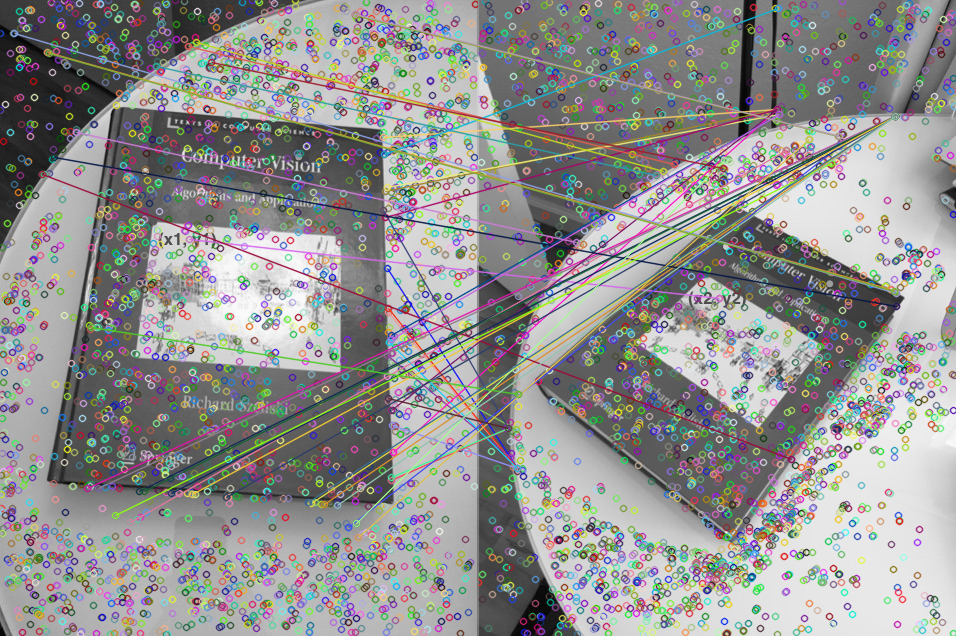

No. of inliers: 14
No. of outliers: 36.0


In [17]:
bfh=cv2.BFMatcher()                                                                         # Created an object of BFMatcher class, which essentially is a Brute-Force Matcher. It helps in matching the descirptors and identifying good-performance matches
matchesh=bfh.match(ds1,ds2)                                                                 # Computing matchings between descriptors of both images, when key-points were Harris Corner Key-Points
matchesh=sorted(matchesh, key=lambda x:x.distance)                                          # Sorting the matches based on the parameter 'distance', which is the Euclidean Distance between the key-points matched
goodMatchesh=matchesh[:50]                                                                  # Taking top-50 matches with least values of distances, hence named as good matches

result=cv2.drawMatches(img1, kp1, img2, kp2, goodMatchesh, None)                            # Drawing line-of-matchings between key-points of good matches

cv2_imshow(result)                                                                          # Displaying the mathces drawn above

img1pts=np.float32([kp1[match.queryIdx].pt for match in goodMatchesh]).reshape(-1,1,2)      # Finding the pixel location of good-matched key-points in the Image 1, which will help in finding the Homography Matrix
img2pts=np.float32([kp2[match.trainIdx].pt for match in goodMatchesh]).reshape(-1,1,2)      # Finding the pixel location of good-matched key-points in the Image 2, which will help in finding the Homography Matrix

M, mask=cv2.findHomography(img1pts,img2pts,cv2.RANSAC,5.0)                                  # Computing Homography Matrix, with the help of above pixel-locations of good-matched key-points, and using RANSAC to find the state with maximum inliers

print("No. of inliers:",np.sum(mask))                                                       # Finding the number of inliers, as mask is a binary array, where 1 means that key-point is an inlier and 0 means that key-point is an outlier
print("No. of outliers:",len(mask)-np.sum(mask))                                            # Finding the number of outliers, as mask is a binary array, where 1 means that key-point is an inlier and 0 means that key-point is an outlier

## **Matching SIFT keypoints of both images**

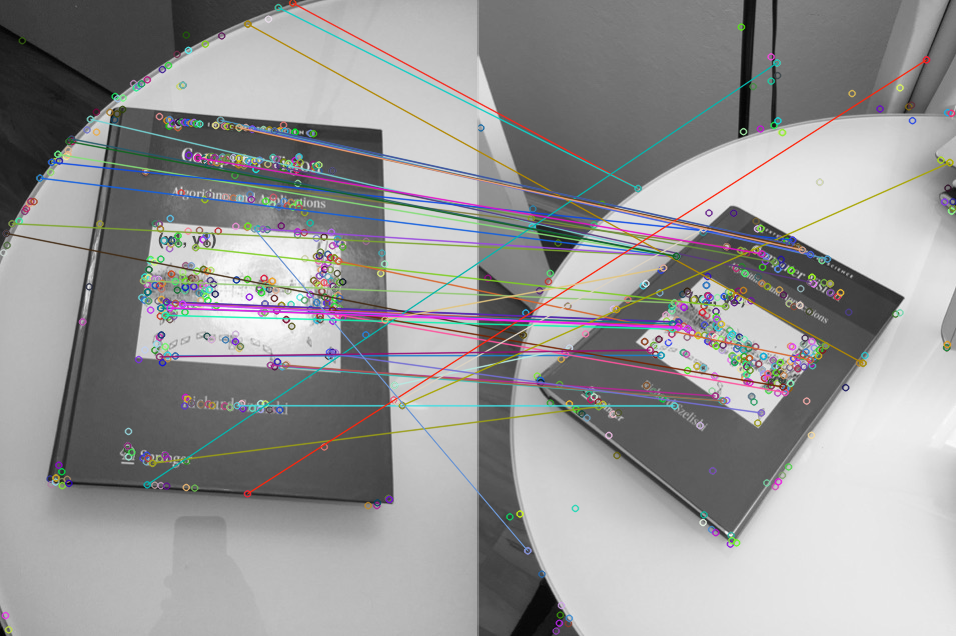

No. of inliers: 27
No. of outliers: 23.0


In [18]:
bf=cv2.BFMatcher()                                                                         # Created an object of BFMatcher class, which essentially is a Brute-Force Matcher. It helps in matching the descirptors and identifying good-performance matches
matches=bf.match(d1,d2)                                                                    # Computing matchings between descriptors of both images, when key-points were detected by SIFT
matches=sorted(matches, key=lambda x:x.distance)                                           # Sorting the matches based on the parameter 'distance', which is the Euclidean Distance between the key-points matched
goodMatches=matches[:50]                                                                   # Taking top-50 matches with least values of distances, hence named as good matches

result=cv2.drawMatches(img1, k1, img2, k2, goodMatches, None)                              # Drawing line-of-matchings between key-points of good matches

cv2_imshow(result)                                                                         # Displaying the mathces drawn above

img1pts=np.float32([k1[match.queryIdx].pt for match in goodMatches]).reshape(-1,1,2)       # Finding the pixel location of good-matched key-points in the Image 1, which will help in finding the Homography Matrix
img2pts=np.float32([k2[match.trainIdx].pt for match in goodMatches]).reshape(-1,1,2)       # Finding the pixel location of good-matched key-points in the Image 2, which will help in finding the Homography Matrix

M, mask=cv2.findHomography(img1pts,img2pts,cv2.RANSAC,5.0)                                 # Computing Homography Matrix, with the help of above pixel-locations of good-matched key-points, and using RANSAC to find the state with maximum inliers

print("No. of inliers:",np.sum(mask))                                                       # Finding the number of inliers, as mask is a binary array, where 1 means that key-point is an inlier and 0 means that key-point is an outlier
print("No. of outliers:",len(mask)-np.sum(mask))                                            # Finding the number of outliers, as mask is a binary array, where 1 means that key-point is an inlier and 0 means that key-point is an outlier

# **Image Stitching**

## **Importing Image and Displaying**

In [61]:
numImgs=int(input("Enter the number of images you want to stitch(>1):"))    # Taking number of images to be stitched as an input
imgs=[]                                                                     # Array to store the images
print("Note: Image 1 means the left-most image and Image",numImgs,"means the right-most image")
for i in range(numImgs):
  inp="Enter Path to Image"+str(i+1)+":"        
  imgPath=input(inp)                                                        # Taking the path of the image as an input from the user in a loop
  imgs.append(cv2.imread(imgPath))                                          # Reading the image from the path and storing the image in the array

Enter the number of images you want to stitch(>1):3
Note: Image 1 means the left-most image and Image 3 means the right-most image
Enter Path to Image1:/content/drive/MyDrive/CV/Project/Data/4a.jpeg
Enter Path to Image2:/content/drive/MyDrive/CV/Project/Data/4b.jpeg
Enter Path to Image3:/content/drive/MyDrive/CV/Project/Data/4c.jpeg


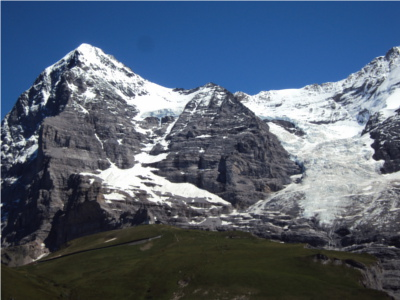

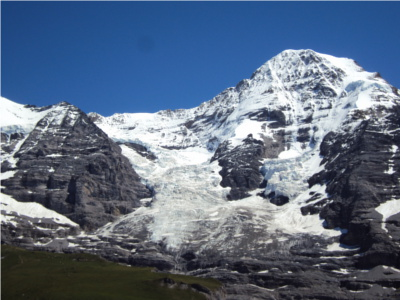

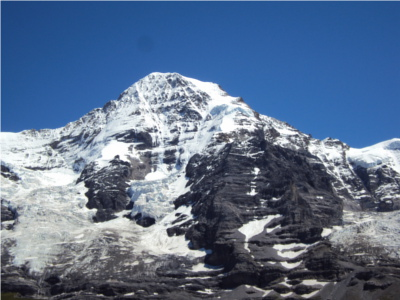

In [62]:
for i in imgs:    # Displaying the images to be stitched
  cv2_imshow(i)

## **Image Stitching using SIFT**

### **Left-To-Right Method**

In [63]:
results=[]                                                                        # Array to store the step-by-step results of stitching

sift=cv2.xfeatures2d.SIFT_create()                                                # Creating object of SIFT_create class, which helps in image matching

for i in range(1,numImgs):                        
  if(i==1):                                                                       # Special Case when the first 2 images are stitched together

    img1=imgs[0]                                                                  # Defining img1 and img2 as the left-image and right-image to be stitched respectively
    img2=imgs[1]                                                                  # Defining img1 and img2 as the left-image and right-image to be stitched respectively

    k1,d1=sift.detectAndCompute(img1,None)                                        # Detecting Key-Points and Computing Descriptors of img1
    k2,d2=sift.detectAndCompute(img2,None)                                        # Detecting Key-Points and Computing Descriptors of img2

    bf=cv2.BFMatcher()                                                            # Created an object of BFMatcher class, which essentially is a Brute-Force Matcher. It helps in matching the descirptors and identifying good-performance matches
    matches=bf.knnMatch(d1,d2,k=2)                                                # Matching Descriptors based on Nearest-Neighbor Algorithm, by considering only 2 neighbors.    

    threshRatio=0.7                                                               # Defining threshold as the maximum value of ratio of distance of match to its nearest neighbor and the distance of same match tp its second-nearest neighbor
    goodMatches=[]                                                                # Array to store the good-matches, matches which are consistent with the above threshold condition  
    for m,n in matches:
      r=m.distance/n.distance                                                     # Computing the ratio of distances, which will be compared with threshold
      if(r<threshRatio):
        goodMatches.append(m)                                                     # Identifying and Storing good-matches from the set of all matches

    points1=np.float32([k1[m.queryIdx].pt for m in goodMatches]).reshape(-1,1,2)  # Finding the pixel location of good-matched key-points in the img1, which will help in finding the Homography Matrix
    points2=np.float32([k2[m.trainIdx].pt for m in goodMatches]).reshape(-1,1,2)  # Finding the pixel location of good-matched key-points in the img2, which will help in finding the Homography Matrix

    cols=img1.shape[1]+img2.shape[1]                                              # Defining the number-of-columns to be present in the resulting stitched image of img1 and img2
    rows=max(img1.shape[0],img2.shape[0])                                         # Defining the number-of-rows to be present in the resulting stitched image of img1 and img2
    res=np.zeros((cols,rows))                                                     # Defining the array which will store the pixel values of the resulting stitched image of img1 and img2  

    if(len(points1)>=4 and len(points2)>=4):                                      # Checking the condition of at-least 4 good-matched key-points, as Homography Matrix requires atleast 4 such points to be computed
      M,mask=cv2.findHomography(points2,points1,cv2.RANSAC,5.0)                   # Computing Homography Matrix, with the help of above pixel-locations of good-matched key-points, and using RANSAC to find the state with maximum inliers
      res=cv2.warpPerspective(img2,M,(cols,rows))                                 # Transforming img2 with the help of Homography Matrix, and storing the transformed result in the above defined array for storing resulting pixel values
      for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
          for k in range(img1.shape[2]):
            res[i,j,k]=max(res[i,j,k],img1[i,j,k])                                # Choosing the maximum of pixel values in the region where we super-impose img1, so that stitching seems continuous
      results.append(res)                                                         # Finally appending the result image in the result array, which stores step-by-step resulting stitched images

  else:
    img1=results[i-2]                                                             # Defining img1 and img2 as the left-image and right-image to be stitched respectively
    img2=imgs[i]                                                                  # Defining img1 and img2 as the left-image and right-image to be stitched respectively

    k1,d1=sift.detectAndCompute(img1,None)                                        # Detecting Key-Points and Computing Descriptors of img1
    k2,d2=sift.detectAndCompute(img2,None)                                        # Detecting Key-Points and Computing Descriptors of img2

    bf=cv2.BFMatcher()                                                            # Created an object of BFMatcher class, which essentially is a Brute-Force Matcher. It helps in matching the descirptors and identifying good-performance matches
    matches=bf.knnMatch(d1,d2,k=2)                                                # Matching Descriptors based on Nearest-Neighbor Algorithm, by considering only 2 neighbors.    

    threshRatio=0.7                                                               # Defining threshold as the maximum value of ratio of distance of match to its nearest neighbor and the distance of same match tp its second-nearest neighbor
    goodMatches=[]                                                                # Array to store the good-matches, matches which are consistent with the above threshold condition  
    for m,n in matches:
      r=m.distance/n.distance                                                     # Computing the ratio of distances, which will be compared with threshold
      if(r<threshRatio):
        goodMatches.append(m)                                                     # Identifying and Storing good-matches from the set of all matches

    points1=np.float32([k1[m.queryIdx].pt for m in goodMatches]).reshape(-1,1,2)  # Finding the pixel location of good-matched key-points in the img1, which will help in finding the Homography Matrix
    points2=np.float32([k2[m.trainIdx].pt for m in goodMatches]).reshape(-1,1,2)  # Finding the pixel location of good-matched key-points in the img2, which will help in finding the Homography Matrix

    cols=img1.shape[1]+img2.shape[1]                                              # Defining the number-of-columns to be present in the resulting stitched image of img1 and img2
    rows=max(img1.shape[0],img2.shape[0])                                         # Defining the number-of-rows to be present in the resulting stitched image of img1 and img2
    res=np.zeros((cols,rows))                                                     # Defining the array which will store the pixel values of the resulting stitched image of img1 and img2  

    if(len(points1)>=4 and len(points2)>=4):                                      # Checking the condition of at-least 4 good-matched key-points, as Homography Matrix requires atleast 4 such points to be computed
      M,mask=cv2.findHomography(points2,points1,cv2.RANSAC,5.0)                   # Computing Homography Matrix, with the help of above pixel-locations of good-matched key-points, and using RANSAC to find the state with maximum inliers
      res=cv2.warpPerspective(img2,M,(cols,rows))                                 # Transforming img2 with the help of Homography Matrix, and storing the transformed result in the above defined array for storing resulting pixel values
      for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
          for k in range(img1.shape[2]):
            res[i,j,k]=max(res[i,j,k],img1[i,j,k])                                # Choosing the maximum of pixel values in the region where we super-impose img1, so that stitching seems continuous
      results.append(res)                                                         # Finally appending the result image in the result array, which stores step-by-step resulting stitched images

Stitched Image from Image 1 to Image 2 :


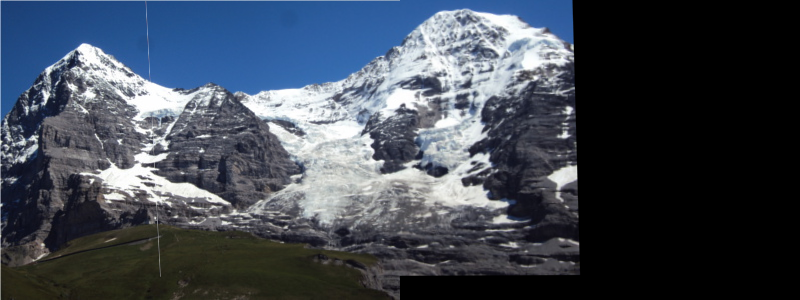

Stitched Image from Image 1 to Image 3 :


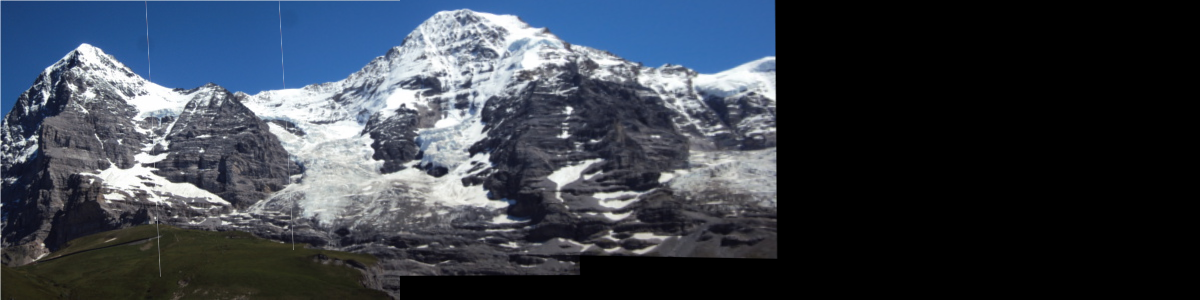

In [64]:
# Displaying the step-by-step resulting stitched images, along with printing the images stitched by that time
for i in range(len(results)):
  print("Stitched Image from Image 1 to Image",i+2,":")
  cv2_imshow(results[i])

### **Right-To-Left Method**

In [65]:
results=[]                                                                        # Array to store the step-by-step results of stitching

sift=cv2.xfeatures2d.SIFT_create()                                                # Creating object of SIFT_create class, which helps in image matching

for i in range(numImgs-2,-1,-1):
  if(i==numImgs-2):                                                               # Special Case when the last 2 images are stitched together

    img1=imgs[i]                                                                  # Defining img1 and img2 as the left-image and right-image to be stitched respectively
    img2=imgs[i+1]                                                                # Defining img1 and img2 as the left-image and right-image to be stitched respectively

    k1,d1=sift.detectAndCompute(img1,None)                                        # Detecting Key-Points and Computing Descriptors of img1
    k2,d2=sift.detectAndCompute(img2,None)                                        # Detecting Key-Points and Computing Descriptors of img2

    bf=cv2.BFMatcher()                                                            # Created an object of BFMatcher class, which essentially is a Brute-Force Matcher. It helps in matching the descirptors and identifying good-performance matches
    matches=bf.knnMatch(d1,d2,k=2)                                                # Matching Descriptors based on Nearest-Neighbor Algorithm, by considering only 2 neighbors.    

    threshRatio=0.7                                                               # Defining threshold as the maximum value of ratio of distance of match to its nearest neighbor and the distance of same match tp its second-nearest neighbor
    goodMatches=[]                                                                # Array to store the good-matches, matches which are consistent with the above threshold condition  
    for m,n in matches:
      r=m.distance/n.distance                                                     # Computing the ratio of distances, which will be compared with threshold
      if(r<threshRatio):
        goodMatches.append(m)                                                     # Identifying and Storing good-matches from the set of all matches

    points1=np.float32([k1[m.queryIdx].pt for m in goodMatches]).reshape(-1,1,2)  # Finding the pixel location of good-matched key-points in the img1, which will help in finding the Homography Matrix
    points2=np.float32([k2[m.trainIdx].pt for m in goodMatches]).reshape(-1,1,2)  # Finding the pixel location of good-matched key-points in the img2, which will help in finding the Homography Matrix

    cols=img1.shape[1]+img2.shape[1]                                              # Defining the number-of-columns to be present in the resulting stitched image of img1 and img2
    rows=max(img1.shape[0],img2.shape[0])                                         # Defining the number-of-rows to be present in the resulting stitched image of img1 and img2
    res=np.zeros((cols,rows))                                                     # Defining the array which will store the pixel values of the resulting stitched image of img1 and img2  

    if(len(points1)>=4 and len(points2)>=4):                                      # Checking the condition of at-least 4 good-matched key-points, as Homography Matrix requires atleast 4 such points to be computed
      M,mask=cv2.findHomography(points2,points1,cv2.RANSAC,5.0)                   # Computing Homography Matrix, with the help of above pixel-locations of good-matched key-points, and using RANSAC to find the state with maximum inliers
      res=cv2.warpPerspective(img2,M,(cols,rows))                                 # Transforming img2 with the help of Homography Matrix, and storing the transformed result in the above defined array for storing resulting pixel values
      for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
          for k in range(img1.shape[2]):
            res[i,j,k]=max(res[i,j,k],img1[i,j,k])                                # Choosing the maximum of pixel values in the region where we super-impose img1, so that stitching seems continuous
      results.append(res)                                                         # Finally appending the result image in the result array, which stores step-by-step resulting stitched images

  else:
    img1=imgs[i]                                                                  # Defining img1 and img2 as the left-image and right-image to be stitched respectively
    img2=results[numImgs-i-3]                                                     # Defining img1 and img2 as the left-image and right-image to be stitched respectively

    k1,d1=sift.detectAndCompute(img1,None)                                        # Detecting Key-Points and Computing Descriptors of img1
    k2,d2=sift.detectAndCompute(img2,None)                                        # Detecting Key-Points and Computing Descriptors of img2

    bf=cv2.BFMatcher()                                                            # Created an object of BFMatcher class, which essentially is a Brute-Force Matcher. It helps in matching the descirptors and identifying good-performance matches
    matches=bf.knnMatch(d1,d2,k=2)                                                # Matching Descriptors based on Nearest-Neighbor Algorithm, by considering only 2 neighbors.    

    threshRatio=0.7                                                               # Defining threshold as the maximum value of ratio of distance of match to its nearest neighbor and the distance of same match tp its second-nearest neighbor
    goodMatches=[]                                                                # Array to store the good-matches, matches which are consistent with the above threshold condition  
    for m,n in matches:
      r=m.distance/n.distance                                                     # Computing the ratio of distances, which will be compared with threshold
      if(r<threshRatio):
        goodMatches.append(m)                                                     # Identifying and Storing good-matches from the set of all matches

    points1=np.float32([k1[m.queryIdx].pt for m in goodMatches]).reshape(-1,1,2)  # Finding the pixel location of good-matched key-points in the img1, which will help in finding the Homography Matrix
    points2=np.float32([k2[m.trainIdx].pt for m in goodMatches]).reshape(-1,1,2)  # Finding the pixel location of good-matched key-points in the img2, which will help in finding the Homography Matrix

    cols=img1.shape[1]+img2.shape[1]                                              # Defining the number-of-columns to be present in the resulting stitched image of img1 and img2
    rows=max(img1.shape[0],img2.shape[0])                                         # Defining the number-of-rows to be present in the resulting stitched image of img1 and img2
    res=np.zeros((cols,rows))                                                     # Defining the array which will store the pixel values of the resulting stitched image of img1 and img2  

    if(len(points1)>=4 and len(points2)>=4):                                      # Checking the condition of at-least 4 good-matched key-points, as Homography Matrix requires atleast 4 such points to be computed
      M,mask=cv2.findHomography(points2,points1,cv2.RANSAC,5.0)                   # Computing Homography Matrix, with the help of above pixel-locations of good-matched key-points, and using RANSAC to find the state with maximum inliers
      res=cv2.warpPerspective(img2,M,(cols,rows))                                 # Transforming img2 with the help of Homography Matrix, and storing the transformed result in the above defined array for storing resulting pixel values
      for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
          for k in range(img1.shape[2]):
            res[i,j,k]=max(res[i,j,k],img1[i,j,k])                                # Choosing the maximum of pixel values in the region where we super-impose img1, so that stitching seems continuous
      results.append(res)                                                         # Finally appending the result image in the result array, which stores step-by-step resulting stitched images

Stitched Image from Image 2 to Image 3 :


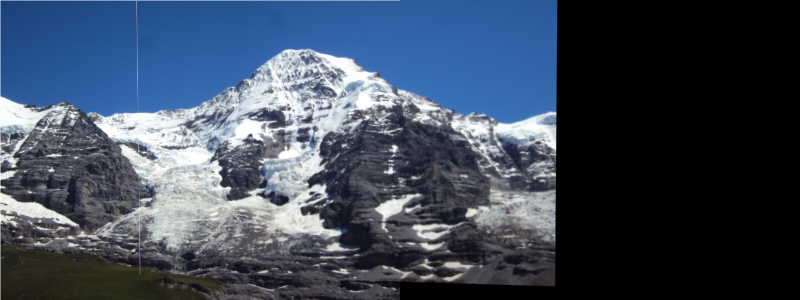

Stitched Image from Image 1 to Image 3 :


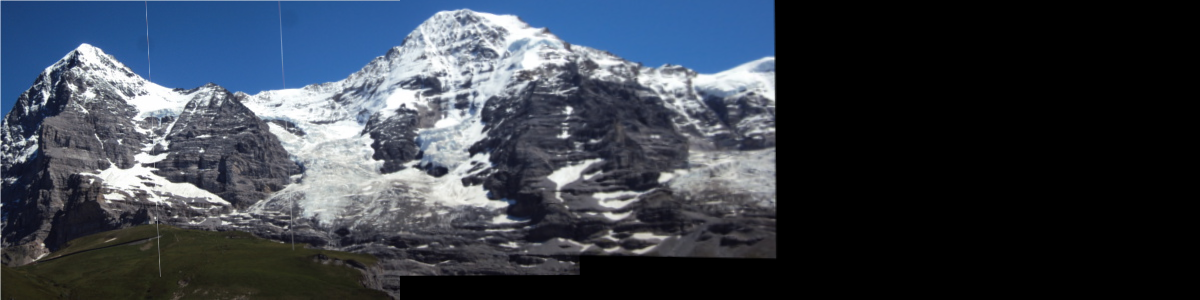

In [66]:
# Displaying the step-by-step resulting stitched images, along with printing the images stitched by that time
for i in range(len(results)):
  print("Stitched Image from Image",numImgs-i-1,"to Image",numImgs,":")
  cv2_imshow(results[i])

## **Image Stitching using ORB**

### **Left-To-Right Method**

In [67]:
results=[]                                                                        # Array to store the step-by-step results of stitching

orb=cv2.ORB_create()                                                              # Creating object of ORB_create class, which helps in image matching

for i in range(1,numImgs):                        
  if(i==1):                                                                       # Special Case when the first 2 images are stitched together

    img1=imgs[0]                                                                  # Defining img1 and img2 as the left-image and right-image to be stitched respectively
    img2=imgs[1]                                                                  # Defining img1 and img2 as the left-image and right-image to be stitched respectively

    k1,d1=orb.detectAndCompute(img1,None)                                         # Detecting Key-Points and Computing Descriptors of img1
    k2,d2=orb.detectAndCompute(img2,None)                                         # Detecting Key-Points and Computing Descriptors of img2

    bf=cv2.BFMatcher()                                                            # Created an object of BFMatcher class, which essentially is a Brute-Force Matcher. It helps in matching the descirptors and identifying good-performance matches
    matches=bf.knnMatch(d1,d2,k=2)                                                # Matching Descriptors based on Nearest-Neighbor Algorithm, by considering only 2 neighbors.    

    threshRatio=0.7                                                               # Defining threshold as the maximum value of ratio of distance of match to its nearest neighbor and the distance of same match tp its second-nearest neighbor
    goodMatches=[]                                                                # Array to store the good-matches, matches which are consistent with the above threshold condition  
    for m,n in matches:
      r=m.distance/n.distance                                                     # Computing the ratio of distances, which will be compared with threshold
      if(r<threshRatio):
        goodMatches.append(m)                                                     # Identifying and Storing good-matches from the set of all matches

    points1=np.float32([k1[m.queryIdx].pt for m in goodMatches]).reshape(-1,1,2)  # Finding the pixel location of good-matched key-points in the img1, which will help in finding the Homography Matrix
    points2=np.float32([k2[m.trainIdx].pt for m in goodMatches]).reshape(-1,1,2)  # Finding the pixel location of good-matched key-points in the img2, which will help in finding the Homography Matrix

    cols=img1.shape[1]+img2.shape[1]                                              # Defining the number-of-columns to be present in the resulting stitched image of img1 and img2
    rows=max(img1.shape[0],img2.shape[0])                                         # Defining the number-of-rows to be present in the resulting stitched image of img1 and img2
    res=np.zeros((cols,rows))                                                     # Defining the array which will store the pixel values of the resulting stitched image of img1 and img2  

    if(len(points1)>=4 and len(points2)>=4):                                      # Checking the condition of at-least 4 good-matched key-points, as Homography Matrix requires atleast 4 such points to be computed
      M,mask=cv2.findHomography(points2,points1,cv2.RANSAC,5.0)                   # Computing Homography Matrix, with the help of above pixel-locations of good-matched key-points, and using RANSAC to find the state with maximum inliers
      res=cv2.warpPerspective(img2,M,(cols,rows))                                 # Transforming img2 with the help of Homography Matrix, and storing the transformed result in the above defined array for storing resulting pixel values
      for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
          for k in range(img1.shape[2]):
            res[i,j,k]=max(res[i,j,k],img1[i,j,k])                                # Choosing the maximum of pixel values in the region where we super-impose img1, so that stitching seems continuous
      results.append(res)                                                         # Finally appending the result image in the result array, which stores step-by-step resulting stitched images

  else:
    img1=results[i-2]                                                             # Defining img1 and img2 as the left-image and right-image to be stitched respectively
    img2=imgs[i]                                                                  # Defining img1 and img2 as the left-image and right-image to be stitched respectively

    k1,d1=orb.detectAndCompute(img1,None)                                         # Detecting Key-Points and Computing Descriptors of img1
    k2,d2=orb.detectAndCompute(img2,None)                                         # Detecting Key-Points and Computing Descriptors of img2

    bf=cv2.BFMatcher()                                                            # Created an object of BFMatcher class, which essentially is a Brute-Force Matcher. It helps in matching the descirptors and identifying good-performance matches
    matches=bf.knnMatch(d1,d2,k=2)                                                # Matching Descriptors based on Nearest-Neighbor Algorithm, by considering only 2 neighbors.    

    threshRatio=0.7                                                               # Defining threshold as the maximum value of ratio of distance of match to its nearest neighbor and the distance of same match tp its second-nearest neighbor
    goodMatches=[]                                                                # Array to store the good-matches, matches which are consistent with the above threshold condition  
    for m,n in matches:
      r=m.distance/n.distance                                                     # Computing the ratio of distances, which will be compared with threshold
      if(r<threshRatio):
        goodMatches.append(m)                                                     # Identifying and Storing good-matches from the set of all matches

    points1=np.float32([k1[m.queryIdx].pt for m in goodMatches]).reshape(-1,1,2)  # Finding the pixel location of good-matched key-points in the img1, which will help in finding the Homography Matrix
    points2=np.float32([k2[m.trainIdx].pt for m in goodMatches]).reshape(-1,1,2)  # Finding the pixel location of good-matched key-points in the img2, which will help in finding the Homography Matrix

    cols=img1.shape[1]+img2.shape[1]                                              # Defining the number-of-columns to be present in the resulting stitched image of img1 and img2
    rows=max(img1.shape[0],img2.shape[0])                                         # Defining the number-of-rows to be present in the resulting stitched image of img1 and img2
    res=np.zeros((cols,rows))                                                     # Defining the array which will store the pixel values of the resulting stitched image of img1 and img2  

    if(len(points1)>=4 and len(points2)>=4):                                      # Checking the condition of at-least 4 good-matched key-points, as Homography Matrix requires atleast 4 such points to be computed
      M,mask=cv2.findHomography(points2,points1,cv2.RANSAC,5.0)                   # Computing Homography Matrix, with the help of above pixel-locations of good-matched key-points, and using RANSAC to find the state with maximum inliers
      res=cv2.warpPerspective(img2,M,(cols,rows))                                 # Transforming img2 with the help of Homography Matrix, and storing the transformed result in the above defined array for storing resulting pixel values
      for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
          for k in range(img1.shape[2]):
            res[i,j,k]=max(res[i,j,k],img1[i,j,k])                                # Choosing the maximum of pixel values in the region where we super-impose img1, so that stitching seems continuous
      results.append(res)                                                         # Finally appending the result image in the result array, which stores step-by-step resulting stitched images

Stitched Image from Image 1 to Image 2 :


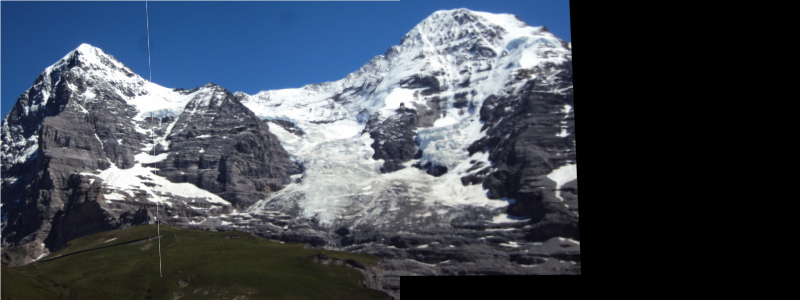

Stitched Image from Image 1 to Image 3 :


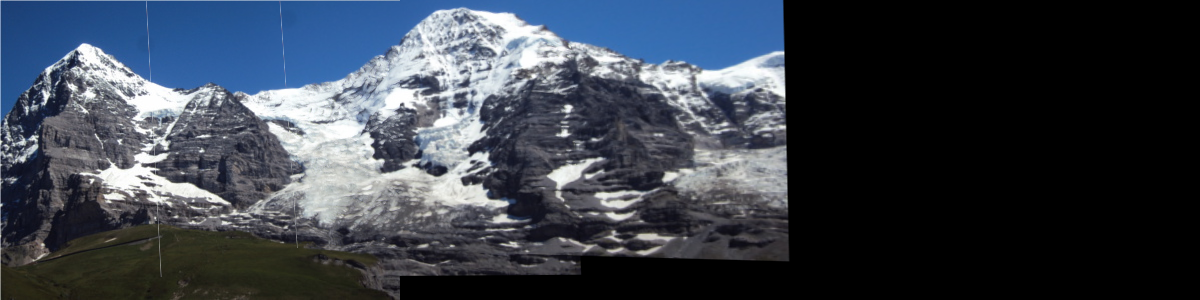

In [68]:
# Displaying the step-by-step resulting stitched images, along with printing the images stitched by that time
for i in range(len(results)):
  print("Stitched Image from Image 1 to Image",i+2,":")
  cv2_imshow(results[i])

### **Right-To-Left Method**

In [69]:
results=[]                                                                        # Array to store the step-by-step results of stitching

orb=cv2.ORB_create()                                                              # Creating object of SIFT_create class, which helps in image matching

for i in range(numImgs-2,-1,-1):
  if(i==numImgs-2):                                                               # Special Case when the last 2 images are stitched together

    img1=imgs[i]                                                                  # Defining img1 and img2 as the left-image and right-image to be stitched respectively
    img2=imgs[i+1]                                                                # Defining img1 and img2 as the left-image and right-image to be stitched respectively

    k1,d1=orb.detectAndCompute(img1,None)                                         # Detecting Key-Points and Computing Descriptors of img1
    k2,d2=orb.detectAndCompute(img2,None)                                         # Detecting Key-Points and Computing Descriptors of img2

    bf=cv2.BFMatcher()                                                            # Created an object of BFMatcher class, which essentially is a Brute-Force Matcher. It helps in matching the descirptors and identifying good-performance matches
    matches=bf.knnMatch(d1,d2,k=2)                                                # Matching Descriptors based on Nearest-Neighbor Algorithm, by considering only 2 neighbors.    

    threshRatio=0.7                                                               # Defining threshold as the maximum value of ratio of distance of match to its nearest neighbor and the distance of same match tp its second-nearest neighbor
    goodMatches=[]                                                                # Array to store the good-matches, matches which are consistent with the above threshold condition  
    for m,n in matches:
      r=m.distance/n.distance                                                     # Computing the ratio of distances, which will be compared with threshold
      if(r<threshRatio):
        goodMatches.append(m)                                                     # Identifying and Storing good-matches from the set of all matches

    points1=np.float32([k1[m.queryIdx].pt for m in goodMatches]).reshape(-1,1,2)  # Finding the pixel location of good-matched key-points in the img1, which will help in finding the Homography Matrix
    points2=np.float32([k2[m.trainIdx].pt for m in goodMatches]).reshape(-1,1,2)  # Finding the pixel location of good-matched key-points in the img2, which will help in finding the Homography Matrix

    cols=img1.shape[1]+img2.shape[1]                                              # Defining the number-of-columns to be present in the resulting stitched image of img1 and img2
    rows=max(img1.shape[0],img2.shape[0])                                         # Defining the number-of-rows to be present in the resulting stitched image of img1 and img2
    res=np.zeros((cols,rows))                                                     # Defining the array which will store the pixel values of the resulting stitched image of img1 and img2  

    if(len(points1)>=4 and len(points2)>=4):                                      # Checking the condition of at-least 4 good-matched key-points, as Homography Matrix requires atleast 4 such points to be computed
      M,mask=cv2.findHomography(points2,points1,cv2.RANSAC,5.0)                   # Computing Homography Matrix, with the help of above pixel-locations of good-matched key-points, and using RANSAC to find the state with maximum inliers
      res=cv2.warpPerspective(img2,M,(cols,rows))                                 # Transforming img2 with the help of Homography Matrix, and storing the transformed result in the above defined array for storing resulting pixel values
      for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
          for k in range(img1.shape[2]):
            res[i,j,k]=max(res[i,j,k],img1[i,j,k])                                # Choosing the maximum of pixel values in the region where we super-impose img1, so that stitching seems continuous
      results.append(res)                                                         # Finally appending the result image in the result array, which stores step-by-step resulting stitched images

  else:
    img1=imgs[i]                                                                  # Defining img1 and img2 as the left-image and right-image to be stitched respectively
    img2=results[numImgs-i-3]                                                     # Defining img1 and img2 as the left-image and right-image to be stitched respectively

    k1,d1=orb.detectAndCompute(img1,None)                                         # Detecting Key-Points and Computing Descriptors of img1
    k2,d2=orb.detectAndCompute(img2,None)                                         # Detecting Key-Points and Computing Descriptors of img2

    bf=cv2.BFMatcher()                                                            # Created an object of BFMatcher class, which essentially is a Brute-Force Matcher. It helps in matching the descirptors and identifying good-performance matches
    matches=bf.knnMatch(d1,d2,k=2)                                                # Matching Descriptors based on Nearest-Neighbor Algorithm, by considering only 2 neighbors.    

    threshRatio=0.7                                                               # Defining threshold as the maximum value of ratio of distance of match to its nearest neighbor and the distance of same match tp its second-nearest neighbor
    goodMatches=[]                                                                # Array to store the good-matches, matches which are consistent with the above threshold condition  
    for m,n in matches:
      r=m.distance/n.distance                                                     # Computing the ratio of distances, which will be compared with threshold
      if(r<threshRatio):
        goodMatches.append(m)                                                     # Identifying and Storing good-matches from the set of all matches

    points1=np.float32([k1[m.queryIdx].pt for m in goodMatches]).reshape(-1,1,2)  # Finding the pixel location of good-matched key-points in the img1, which will help in finding the Homography Matrix
    points2=np.float32([k2[m.trainIdx].pt for m in goodMatches]).reshape(-1,1,2)  # Finding the pixel location of good-matched key-points in the img2, which will help in finding the Homography Matrix

    cols=img1.shape[1]+img2.shape[1]                                              # Defining the number-of-columns to be present in the resulting stitched image of img1 and img2
    rows=max(img1.shape[0],img2.shape[0])                                         # Defining the number-of-rows to be present in the resulting stitched image of img1 and img2
    res=np.zeros((cols,rows))                                                     # Defining the array which will store the pixel values of the resulting stitched image of img1 and img2  

    if(len(points1)>=4 and len(points2)>=4):                                      # Checking the condition of at-least 4 good-matched key-points, as Homography Matrix requires atleast 4 such points to be computed
      M,mask=cv2.findHomography(points2,points1,cv2.RANSAC,5.0)                   # Computing Homography Matrix, with the help of above pixel-locations of good-matched key-points, and using RANSAC to find the state with maximum inliers
      res=cv2.warpPerspective(img2,M,(cols,rows))                                 # Transforming img2 with the help of Homography Matrix, and storing the transformed result in the above defined array for storing resulting pixel values
      for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
          for k in range(img1.shape[2]):
            res[i,j,k]=max(res[i,j,k],img1[i,j,k])                                # Choosing the maximum of pixel values in the region where we super-impose img1, so that stitching seems continuous
      results.append(res)                                                         # Finally appending the result image in the result array, which stores step-by-step resulting stitched images

Stitched Image from Image 2 to Image 3 :


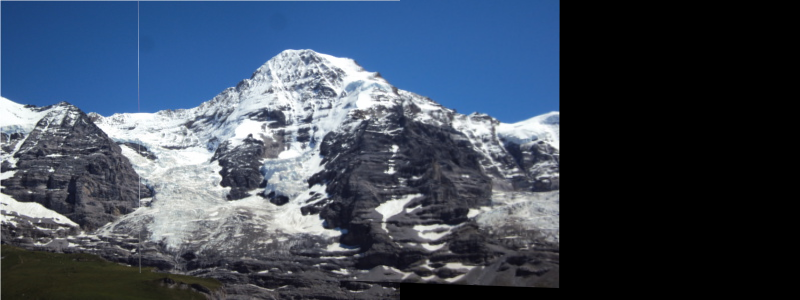

Stitched Image from Image 1 to Image 3 :


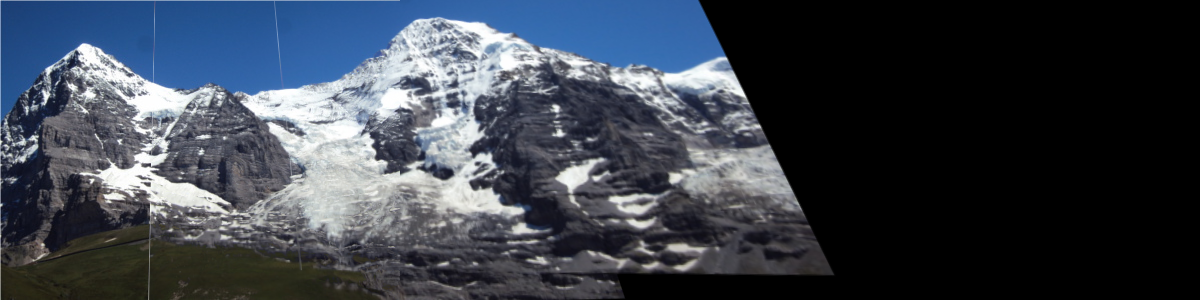

In [70]:
# Displaying the step-by-step resulting stitched images, along with printing the images stitched by that time
for i in range(len(results)):
  print("Stitched Image from Image",numImgs-i-1,"to Image",numImgs,":")
  cv2_imshow(results[i])

## **Image Stitching using BRISK**

### **Left-To-Right Method**

In [71]:
results=[]                                                                        # Array to store the step-by-step results of stitching

brisk=cv2.BRISK_create()                                                          # Creating object of BRISK_create class, which helps in image matching

for i in range(1,numImgs):                        
  if(i==1):                                                                       # Special Case when the first 2 images are stitched together

    img1=imgs[0]                                                                  # Defining img1 and img2 as the left-image and right-image to be stitched respectively
    img2=imgs[1]                                                                  # Defining img1 and img2 as the left-image and right-image to be stitched respectively

    k1,d1=brisk.detectAndCompute(img1,None)                                       # Detecting Key-Points and Computing Descriptors of img1
    k2,d2=brisk.detectAndCompute(img2,None)                                       # Detecting Key-Points and Computing Descriptors of img2

    bf=cv2.BFMatcher()                                                            # Created an object of BFMatcher class, which essentially is a Brute-Force Matcher. It helps in matching the descirptors and identifying good-performance matches
    matches=bf.knnMatch(d1,d2,k=2)                                                # Matching Descriptors based on Nearest-Neighbor Algorithm, by considering only 2 neighbors.    

    threshRatio=0.7                                                               # Defining threshold as the maximum value of ratio of distance of match to its nearest neighbor and the distance of same match tp its second-nearest neighbor
    goodMatches=[]                                                                # Array to store the good-matches, matches which are consistent with the above threshold condition  
    for m,n in matches:
      r=m.distance/n.distance                                                     # Computing the ratio of distances, which will be compared with threshold
      if(r<threshRatio):
        goodMatches.append(m)                                                     # Identifying and Storing good-matches from the set of all matches

    points1=np.float32([k1[m.queryIdx].pt for m in goodMatches]).reshape(-1,1,2)  # Finding the pixel location of good-matched key-points in the img1, which will help in finding the Homography Matrix
    points2=np.float32([k2[m.trainIdx].pt for m in goodMatches]).reshape(-1,1,2)  # Finding the pixel location of good-matched key-points in the img2, which will help in finding the Homography Matrix

    cols=img1.shape[1]+img2.shape[1]                                              # Defining the number-of-columns to be present in the resulting stitched image of img1 and img2
    rows=max(img1.shape[0],img2.shape[0])                                         # Defining the number-of-rows to be present in the resulting stitched image of img1 and img2
    res=np.zeros((cols,rows))                                                     # Defining the array which will store the pixel values of the resulting stitched image of img1 and img2  

    if(len(points1)>=4 and len(points2)>=4):                                      # Checking the condition of at-least 4 good-matched key-points, as Homography Matrix requires atleast 4 such points to be computed
      M,mask=cv2.findHomography(points2,points1,cv2.RANSAC,5.0)                   # Computing Homography Matrix, with the help of above pixel-locations of good-matched key-points, and using RANSAC to find the state with maximum inliers
      res=cv2.warpPerspective(img2,M,(cols,rows))                                 # Transforming img2 with the help of Homography Matrix, and storing the transformed result in the above defined array for storing resulting pixel values
      for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
          for k in range(img1.shape[2]):
            res[i,j,k]=max(res[i,j,k],img1[i,j,k])                                # Choosing the maximum of pixel values in the region where we super-impose img1, so that stitching seems continuous
      results.append(res)                                                         # Finally appending the result image in the result array, which stores step-by-step resulting stitched images

  else:
    img1=results[i-2]                                                             # Defining img1 and img2 as the left-image and right-image to be stitched respectively
    img2=imgs[i]                                                                  # Defining img1 and img2 as the left-image and right-image to be stitched respectively

    k1,d1=brisk.detectAndCompute(img1,None)                                       # Detecting Key-Points and Computing Descriptors of img1
    k2,d2=brisk.detectAndCompute(img2,None)                                       # Detecting Key-Points and Computing Descriptors of img2

    bf=cv2.BFMatcher()                                                            # Created an object of BFMatcher class, which essentially is a Brute-Force Matcher. It helps in matching the descirptors and identifying good-performance matches
    matches=bf.knnMatch(d1,d2,k=2)                                                # Matching Descriptors based on Nearest-Neighbor Algorithm, by considering only 2 neighbors.    

    threshRatio=0.7                                                               # Defining threshold as the maximum value of ratio of distance of match to its nearest neighbor and the distance of same match tp its second-nearest neighbor
    goodMatches=[]                                                                # Array to store the good-matches, matches which are consistent with the above threshold condition  
    for m,n in matches:
      r=m.distance/n.distance                                                     # Computing the ratio of distances, which will be compared with threshold
      if(r<threshRatio):
        goodMatches.append(m)                                                     # Identifying and Storing good-matches from the set of all matches

    points1=np.float32([k1[m.queryIdx].pt for m in goodMatches]).reshape(-1,1,2)  # Finding the pixel location of good-matched key-points in the img1, which will help in finding the Homography Matrix
    points2=np.float32([k2[m.trainIdx].pt for m in goodMatches]).reshape(-1,1,2)  # Finding the pixel location of good-matched key-points in the img2, which will help in finding the Homography Matrix

    cols=img1.shape[1]+img2.shape[1]                                              # Defining the number-of-columns to be present in the resulting stitched image of img1 and img2
    rows=max(img1.shape[0],img2.shape[0])                                         # Defining the number-of-rows to be present in the resulting stitched image of img1 and img2
    res=np.zeros((cols,rows))                                                     # Defining the array which will store the pixel values of the resulting stitched image of img1 and img2  

    if(len(points1)>=4 and len(points2)>=4):                                      # Checking the condition of at-least 4 good-matched key-points, as Homography Matrix requires atleast 4 such points to be computed
      M,mask=cv2.findHomography(points2,points1,cv2.RANSAC,5.0)                   # Computing Homography Matrix, with the help of above pixel-locations of good-matched key-points, and using RANSAC to find the state with maximum inliers
      res=cv2.warpPerspective(img2,M,(cols,rows))                                 # Transforming img2 with the help of Homography Matrix, and storing the transformed result in the above defined array for storing resulting pixel values
      for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
          for k in range(img1.shape[2]):
            res[i,j,k]=max(res[i,j,k],img1[i,j,k])                                # Choosing the maximum of pixel values in the region where we super-impose img1, so that stitching seems continuous
      results.append(res)                                                         # Finally appending the result image in the result array, which stores step-by-step resulting stitched images

Stitched Image from Image 1 to Image 2 :


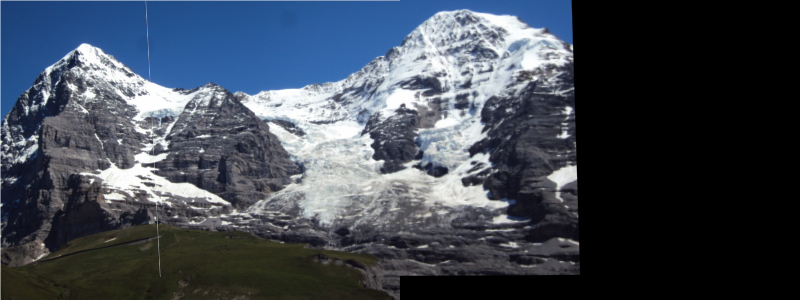

Stitched Image from Image 1 to Image 3 :


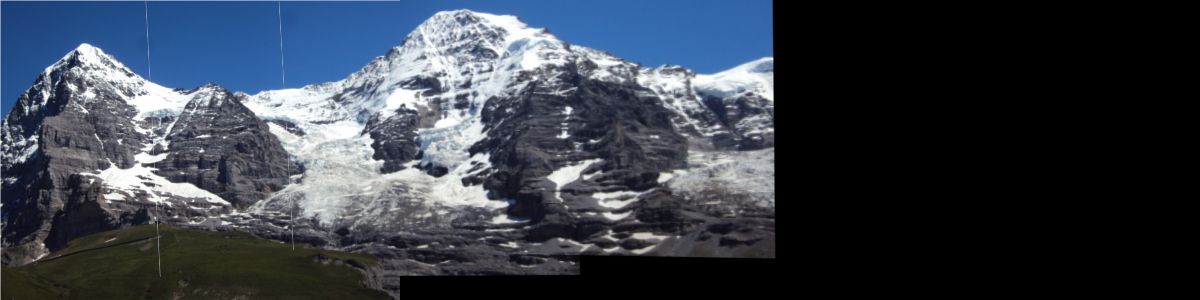

In [72]:
# Displaying the step-by-step resulting stitched images, along with printing the images stitched by that time
for i in range(len(results)):
  print("Stitched Image from Image 1 to Image",i+2,":")
  cv2_imshow(results[i])

### **Right-To-Left Method**

In [73]:
results=[]                                                                        # Array to store the step-by-step results of stitching

brisk=cv2.BRISK_create()                                                          # Creating object of SIFT_create class, which helps in image matching

for i in range(numImgs-2,-1,-1):
  if(i==numImgs-2):                                                               # Special Case when the last 2 images are stitched together

    img1=imgs[i]                                                                  # Defining img1 and img2 as the left-image and right-image to be stitched respectively
    img2=imgs[i+1]                                                                # Defining img1 and img2 as the left-image and right-image to be stitched respectively

    k1,d1=brisk.detectAndCompute(img1,None)                                       # Detecting Key-Points and Computing Descriptors of img1
    k2,d2=brisk.detectAndCompute(img2,None)                                       # Detecting Key-Points and Computing Descriptors of img2

    bf=cv2.BFMatcher()                                                            # Created an object of BFMatcher class, which essentially is a Brute-Force Matcher. It helps in matching the descirptors and identifying good-performance matches
    matches=bf.knnMatch(d1,d2,k=2)                                                # Matching Descriptors based on Nearest-Neighbor Algorithm, by considering only 2 neighbors.    

    threshRatio=0.7                                                               # Defining threshold as the maximum value of ratio of distance of match to its nearest neighbor and the distance of same match tp its second-nearest neighbor
    goodMatches=[]                                                                # Array to store the good-matches, matches which are consistent with the above threshold condition  
    for m,n in matches:
      r=m.distance/n.distance                                                     # Computing the ratio of distances, which will be compared with threshold
      if(r<threshRatio):
        goodMatches.append(m)                                                     # Identifying and Storing good-matches from the set of all matches

    points1=np.float32([k1[m.queryIdx].pt for m in goodMatches]).reshape(-1,1,2)  # Finding the pixel location of good-matched key-points in the img1, which will help in finding the Homography Matrix
    points2=np.float32([k2[m.trainIdx].pt for m in goodMatches]).reshape(-1,1,2)  # Finding the pixel location of good-matched key-points in the img2, which will help in finding the Homography Matrix

    cols=img1.shape[1]+img2.shape[1]                                              # Defining the number-of-columns to be present in the resulting stitched image of img1 and img2
    rows=max(img1.shape[0],img2.shape[0])                                         # Defining the number-of-rows to be present in the resulting stitched image of img1 and img2
    res=np.zeros((cols,rows))                                                     # Defining the array which will store the pixel values of the resulting stitched image of img1 and img2  

    if(len(points1)>=4 and len(points2)>=4):                                      # Checking the condition of at-least 4 good-matched key-points, as Homography Matrix requires atleast 4 such points to be computed
      M,mask=cv2.findHomography(points2,points1,cv2.RANSAC,5.0)                   # Computing Homography Matrix, with the help of above pixel-locations of good-matched key-points, and using RANSAC to find the state with maximum inliers
      res=cv2.warpPerspective(img2,M,(cols,rows))                                 # Transforming img2 with the help of Homography Matrix, and storing the transformed result in the above defined array for storing resulting pixel values
      for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
          for k in range(img1.shape[2]):
            res[i,j,k]=max(res[i,j,k],img1[i,j,k])                                # Choosing the maximum of pixel values in the region where we super-impose img1, so that stitching seems continuous
      results.append(res)                                                         # Finally appending the result image in the result array, which stores step-by-step resulting stitched images

  else:
    img1=imgs[i]                                                                  # Defining img1 and img2 as the left-image and right-image to be stitched respectively
    img2=results[numImgs-i-3]                                                     # Defining img1 and img2 as the left-image and right-image to be stitched respectively

    k1,d1=brisk.detectAndCompute(img1,None)                                       # Detecting Key-Points and Computing Descriptors of img1
    k2,d2=brisk.detectAndCompute(img2,None)                                       # Detecting Key-Points and Computing Descriptors of img2

    bf=cv2.BFMatcher()                                                            # Created an object of BFMatcher class, which essentially is a Brute-Force Matcher. It helps in matching the descirptors and identifying good-performance matches
    matches=bf.knnMatch(d1,d2,k=2)                                                # Matching Descriptors based on Nearest-Neighbor Algorithm, by considering only 2 neighbors.    

    threshRatio=0.7                                                               # Defining threshold as the maximum value of ratio of distance of match to its nearest neighbor and the distance of same match tp its second-nearest neighbor
    goodMatches=[]                                                                # Array to store the good-matches, matches which are consistent with the above threshold condition  
    for m,n in matches:
      r=m.distance/n.distance                                                     # Computing the ratio of distances, which will be compared with threshold
      if(r<threshRatio):
        goodMatches.append(m)                                                     # Identifying and Storing good-matches from the set of all matches

    points1=np.float32([k1[m.queryIdx].pt for m in goodMatches]).reshape(-1,1,2)  # Finding the pixel location of good-matched key-points in the img1, which will help in finding the Homography Matrix
    points2=np.float32([k2[m.trainIdx].pt for m in goodMatches]).reshape(-1,1,2)  # Finding the pixel location of good-matched key-points in the img2, which will help in finding the Homography Matrix

    cols=img1.shape[1]+img2.shape[1]                                              # Defining the number-of-columns to be present in the resulting stitched image of img1 and img2
    rows=max(img1.shape[0],img2.shape[0])                                         # Defining the number-of-rows to be present in the resulting stitched image of img1 and img2
    res=np.zeros((cols,rows))                                                     # Defining the array which will store the pixel values of the resulting stitched image of img1 and img2  

    if(len(points1)>=4 and len(points2)>=4):                                      # Checking the condition of at-least 4 good-matched key-points, as Homography Matrix requires atleast 4 such points to be computed
      M,mask=cv2.findHomography(points2,points1,cv2.RANSAC,5.0)                   # Computing Homography Matrix, with the help of above pixel-locations of good-matched key-points, and using RANSAC to find the state with maximum inliers
      res=cv2.warpPerspective(img2,M,(cols,rows))                                 # Transforming img2 with the help of Homography Matrix, and storing the transformed result in the above defined array for storing resulting pixel values
      for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
          for k in range(img1.shape[2]):
            res[i,j,k]=max(res[i,j,k],img1[i,j,k])                                # Choosing the maximum of pixel values in the region where we super-impose img1, so that stitching seems continuous
      results.append(res)                                                         # Finally appending the result image in the result array, which stores step-by-step resulting stitched images

Stitched Image from Image 2 to Image 3 :


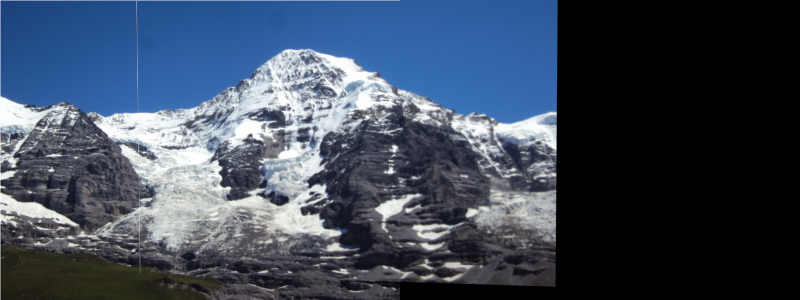

Stitched Image from Image 1 to Image 3 :


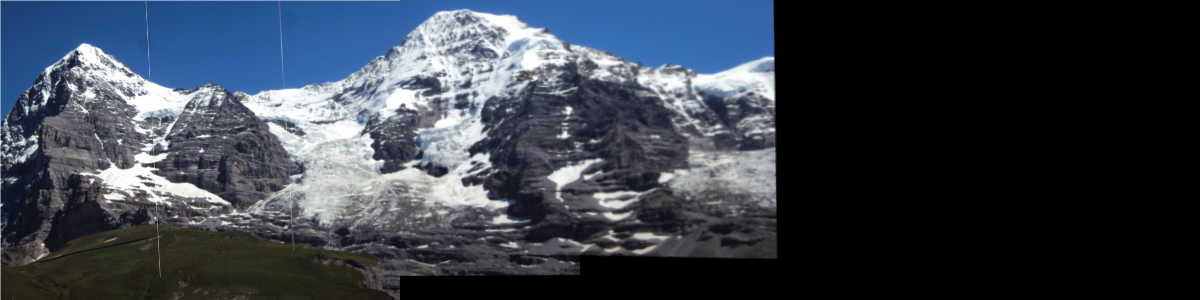

In [74]:
# Displaying the step-by-step resulting stitched images, along with printing the images stitched by that time
for i in range(len(results)):
  print("Stitched Image from Image",numImgs-i-1,"to Image",numImgs,":")
  cv2_imshow(results[i])

# **NMS vs non-NMS in Harris Corner**

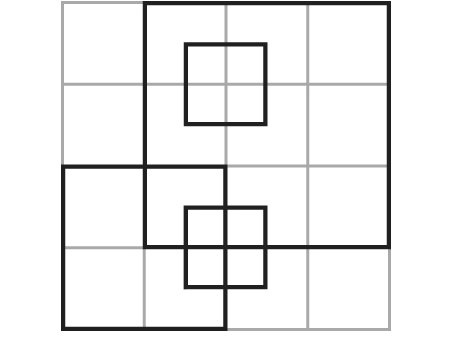

In [75]:
imgPath='/content/drive/MyDrive/CV/Project/Data/box.jpg'      # Path of the Image used for Comparison between with-NMS and without-NMS
img=cv2.imread(imgPath)                                       # Reading the Image from its path
img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)                      # Converting Image from RGB (3 channel) to GrayScale (1 channel) for better corner and key-point detection
cv2_imshow(img)                                               # Displaying the Image

Number of corners detected are: 34


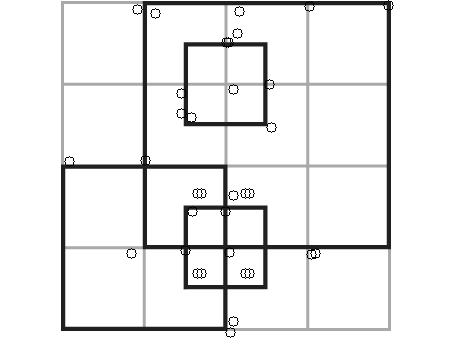

In [76]:
thresh=0.97                                       # Threshold signifying the minimum value of the ratio of Harris Corner Response Function of a particular pixel, to the maximum value of Harris Corner Response Function
r=cornerDetect(img,0.05)                          # Detecting and Retreiving Harris Corner Response Matrix for Image, with k=0.05.
mmax=np.max(r)                                    # Finding the maximum value of Harris Corner Response Function for Image
cimg=img.copy()                                   # Creating a copy of the image, so that corners can be drawn on the copy
count=0                                           # Variable to store the quantity of corners detected
for i in range(r.shape[0]):
  for j in range(r.shape[1]):
    if(float(r[i,j])>float(thresh*mmax)):         # Identifying those pixels in Image, which have ratio of Harris Corner Response Function Value to Maximum of Harris Corner Response Function Values more than the threshold
      cv2.circle(cimg,(j,i),5,0,1)                # Drawing a circle with that pixel as center and radius of 5 pixel and thickness of 1 pixel
      count+=1                                    # increasing the variable storing the quantity of corners detected
print("Number of corners detected are:",count)    # Printing the number of corners detected
cv2_imshow(cimg)                                  # Displaying the image with circles drawn to identify corners detected

Number of corners detected are: 54


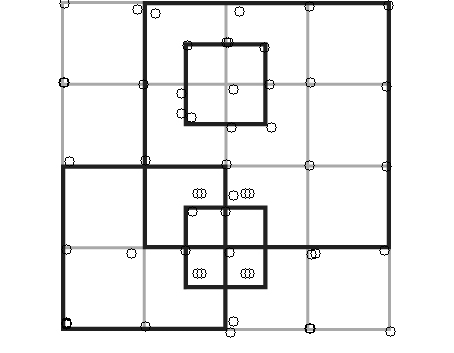

In [77]:
thresh=0.4                                                                            # Threshold signifying the minimum value of the ratio of Harris Corner Response Function of a particular pixel, to the maximum value of Harris Corner Response Function

kernel_size=49                                                                        # Defining kernel-size of the window used to apply NMS
rNMS=cornerDetect(img,0.05)                                                           # Detecting and Retreiving Harris Corner Response Matrix for Image, with k=0.05.
rNMSmod=np.zeros_like(rNMS)                                                           # Creating a zero-filled matrix to store Harris Corner Response Function Values after applying NMS
for i in range(rNMS.shape[0]):
  for j in range(rNMS.shape[1]):
    minrow,maxrow=max(0,i-(kernel_size//2)),min(i+(kernel_size//2)+1,rNMS.shape[0])   # Defining the minimum and maximum value of rows, which are within the bounds of kernel/window
    mincol,maxcol=max(0,j-(kernel_size//2)),min(j+(kernel_size//2)+1,rNMS.shape[1])   # Defining the minimum and maximum value of columns, which are within the bounds of kernel/window
    if(float(rNMS[i,j])==float(np.max(rNMS[minrow:maxrow,mincol:maxcol]))):           # Checking whether the current pixel has the maximum Harris Corner Response Function value in the whole window or not
      rNMSmod[i,j]=float(rNMS[i,j])                                                   # If current pixel has the maximum value then we fill that value in corresponding location in the new matrix initialized with 0, to store modified Harris Corner Response Function

mmax=np.max(rNMSmod)                                                                  # Finding the maximum value of Modified Harris Corner Response Function for Image
cimg=img.copy()                                                                       # Creating a copy of the image, so that corners can be drawn on the copy
count=0                                                                               # Variable to store the quantity of corners detected
for i in range(rNMSmod.shape[0]):
  for j in range(rNMSmod.shape[1]):
    if(float(rNMSmod[i,j])>float(thresh*mmax)):                                       # Identifying those pixels in Image, which have ratio of Modified Harris Corner Response Function Value to Modified Maximum of Harris Corner Response Function Values more than the threshold
      cv2.circle(cimg,(j,i),5,0,1)                                                    # Drawing a circle with that pixel as center and radius of 5 pixel and thickness of 1 pixel
      count+=1                                                                        # increasing the variable storing the quantity of corners detected
print("Number of corners detected are:",count)                                        # Printing the number of corners detected
cv2_imshow(cimg)                                                                      # Displaying the image with circles drawn to identify corners detected